In [ ]:
import pandas as pd, numpy as np, os
from google.colab import drive
import torch, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import random

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # for multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

file_train = 'data/train_imputed.csv'
file_val = 'data/validation_imputed.csv'

drive.mount('/content/drive')


os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['o3',
 'data',
 'Copy of LSTM.ipynb',
 'models',
 'rnn-keras.ipynb',
 'results',
 'ML-project-Preliminaries.gdoc',
 'Presentation',
 'old-rnn-univar.ipynb',
 'old-data-normalization.ipynb',
 'convert-to-tensor.ipynb',
 'model_state_dict.pth',
 'training_results_univariant.csv',
 'LSTM.ipynb',
 'old-rnn-multivar.ipynb',
 'final-code',
 'ML-Report.gdoc']

In [ ]:
os.chdir('drive/MyDrive/ML-project')

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/ML-project'

In [ ]:
import os

# Print current working directory
print("Current Working Directory: ", os.getcwd())

# Try to list contents of the current directory or a known directory
print("Contents of the current directory: ", os.listdir())

# Use an absolute path (modify this according to your file system)
absolute_path = '/path/to/drive/MyDrive/ML-project'

# Check if the path exists
if os.path.exists(absolute_path):
    os.chdir(absolute_path)
    print("Changed directory to: ", os.getcwd())
    print("Contents of ML-project directory: ", os.listdir())
else:
    print("Directory not found: ", absolute_path)


Current Working Directory:  /content/drive/.shortcut-targets-by-id/1TXiJHdcw3NpU4djnyH6iRTWY2sTP877t/ML-project
Contents of the current directory:  ['o3', 'data', 'Copy of LSTM.ipynb', 'models', 'rnn-keras.ipynb', 'results', 'ML-project-Preliminaries.gdoc', 'Presentation', 'old-rnn-univar.ipynb', 'old-data-normalization.ipynb', 'convert-to-tensor.ipynb', 'model_state_dict.pth', 'training_results_univariant.csv', 'LSTM.ipynb', 'old-rnn-multivar.ipynb', 'final-code', 'ML-Report.gdoc']
Directory not found:  /path/to/drive/MyDrive/ML-project


In [ ]:
os.listdir()

['o3',
 'data',
 'Copy of LSTM.ipynb',
 'models',
 'rnn-keras.ipynb',
 'results',
 'ML-project-Preliminaries.gdoc',
 'Presentation',
 'old-rnn-univar.ipynb',
 'old-data-normalization.ipynb',
 'convert-to-tensor.ipynb',
 'model_state_dict.pth',
 'training_results_univariant.csv',
 'LSTM.ipynb',
 'old-rnn-multivar.ipynb',
 'final-code',
 'ML-Report.gdoc']

# Data

In [ ]:
def create_dataset(datasetx, datasety, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps - make sure the first element per array is the y variable
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(datasetx)-lookback):
        feature = datasetx[i:i+lookback]
        target = datasety[i+1:i+lookback+1] #[dataset[i+1:i+lookback+1,0]]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

def generate_data(lookback,
                  file_train=file_train, file_val=file_val,
                  predvar='no2', exog=[], plot=False):
  # Read and visualize data
  df=pd.read_csv(file_train)
  val=pd.read_csv(file_val)
  timeseries=pd.concat([df,val], ignore_index=True)[[predvar]+exog].values.astype('float32')
  train_size=len(df)
  val_size = len(timeseries) - train_size
  print(f"Train size: {train_size}\nTest size: {val_size}")
  train, val = timeseries[:train_size], timeseries[train_size:]

  if plot:
    plt.plot(train)
    plt.show()

    plt.plot(val)
    plt.show()

  # normalize data
  scalerx = MinMaxScaler(feature_range=(0,1))
  scalery = MinMaxScaler(feature_range=(0,1))

  # scaling dataset
  scaled_trainx = scalerx.fit_transform(train)
  scaled_trainy = scalery.fit_transform(train[:,0].reshape(-1, 1))

  # scale validation
  scaled_valx = scalerx.transform(val)
  scaled_valy = scalery.transform(val[:,0].reshape(-1, 1))

  # Split data and introduce lookback
  X_train, y_train = create_dataset(scaled_trainx, scaled_trainy, lookback=lookback)
  X_val, y_val = create_dataset(scaled_valx, scaled_valy, lookback=lookback)
  print(X_train.shape, y_train.shape)
  print(X_val.shape, y_val.shape)

  return timeseries, train_size, train, val, scalerx, scalery, X_train, y_train, X_val, y_val

In [ ]:
# Categorize available columns in dataset
cols=['time', 'o3', 'wind', 'temp', 'no2', 'no', 'nox', 'year',
      'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
      'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
      'week_1', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9',
      'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
      'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
      'hday_lundi_de_pâques', 'hday_fête_du_travail', 'hday_fête_de_la_victoire', 'hday_ascension', 'hday_lundi_de_pentecôte', 'hday_fête_nationale', 'hday_assomption', 'hday_toussaint', 'hday_armistice', 'hday_noël', 'hday_jour_de_l_an',
      'hday', 'hday_after1', 'hday_before1']

cols_nontime=['wind', 'temp']
cols_hday=['hday', 'hday_after1', 'hday_before1']
cols_specific_hday=[i for i in cols if i.startswith('hday_') and i not in ['hday_after1','hday_before1']]
cols_month=[i for i in cols if i.startswith('month_')]
cols_weekday=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed']
cols_day=[i for i in cols if i.startswith('day_') and i not in cols_weekday]
cols_week=[i for i in cols if i.startswith('week_')]
cols_hour=[i for i in cols if i.startswith('hr_')]

In [ ]:
# ADJUST VARIABLES
predvar='no2'
exog=cols_specific_hday+cols_weekday+cols_month+cols_hour
lookback = 1
# lookback=168
input_size=len(exog)+1

timeseries, val_size, train, val, scalerx, scalery, X_train, y_train, X_val, y_val=generate_data(lookback=lookback,
                                                                    file_train=file_train, file_val=file_val,
                                                                    predvar='no2', exog=exog, plot=False)

Train size: 17520
Test size: 4416
torch.Size([17519, 1, 55]) torch.Size([17519, 1, 1])
torch.Size([4415, 1, 55]) torch.Size([4415, 1, 1])



# **The multivariate LSTM**



## Architechtures

### With dropout

In [ ]:
class MultivariateLSTM(nn.Module):
    def __init__(self):
        super(MultivariateLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=50, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(50, 50, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
          x, _ = self.lstm1(x)
          x = self.dropout(x)
          x, _ = self.lstm2(x)
          x = x[:, -1, :]
          x = self.linear(x)
          return x

In [ ]:
os.listdir("models/new")

['best_model_state_multi_dict.pth',
 'final_rmse_results_MultivariateLSTM_withdrop.csv',
 'final_rmse_results_MultivariateLSTM_vanilla.csv',
 'final_rmse_results_MultivariateLSTM.csv',
 'best_model_state_multi__bi_dict.pth',
 'final_rmse_results_MultivariateLSTM_bi.csv',
 'best_model_state_1_8_0.001_8.pth',
 'final_rmse_results_MultivariateLSTM_tunning.csv']

In [ ]:
# Instantiating the model
model = MultivariateLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train_tensor = X_train.clone().detach().requires_grad_(False).float()
y_train_tensor = y_train.view(-1, 1)
X_val_tensor = X_val.clone().detach().requires_grad_(False).float()
y_val_tensor = y_val.view(-1, 1)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=8, shuffle=False)

# Train and validation RMSE calculation function
def calculate_rmse(model, data_loader):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            count += 1
    return np.sqrt(total_loss / count)

train_losses = []
validation_losses = []
epoch_values = []

# Training loop
n_epochs = 10
best_val_rmse = float('inf')

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

    # Calculate RMSE after each epoch
    train_rmse = calculate_rmse(model, train_loader)
    val_rmse = calculate_rmse(model, val_loader)
    print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f}")

    # Save best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'models/new/best_model_state_multi_dict.pth')

    # Store losses for each epoch
    train_losses.append(train_rmse)
    validation_losses.append(val_rmse)
    epoch_values.append(epoch)

final_train_rmse = calculate_rmse(model, train_loader)
final_val_rmse = calculate_rmse(model, val_loader)
print(f"Final: Train RMSE {final_train_rmse:.4f}, Validation RMSE {final_val_rmse:.4f}")
# Create a DataFrame with the results
final_results_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Validation RMSE'],
    'Value': [final_train_rmse, final_val_rmse]
})

final_results_df.to_csv('models/new/final_rmse_results_MultivariateLSTM_withdrop.csv', index=False)
# print(final_results_df)

Epoch 0: Train RMSE 0.0497, Validation RMSE 0.0531
Epoch 1: Train RMSE 0.0458, Validation RMSE 0.0494
Epoch 2: Train RMSE 0.0463, Validation RMSE 0.0487
Epoch 3: Train RMSE 0.0451, Validation RMSE 0.0477
Epoch 4: Train RMSE 0.0490, Validation RMSE 0.0533
Epoch 5: Train RMSE 0.0467, Validation RMSE 0.0500
Epoch 6: Train RMSE 0.0456, Validation RMSE 0.0493
Epoch 7: Train RMSE 0.0442, Validation RMSE 0.0480
Epoch 8: Train RMSE 0.0446, Validation RMSE 0.0491
Epoch 9: Train RMSE 0.0449, Validation RMSE 0.0496
Final: Train RMSE 0.0449, Validation RMSE 0.0496


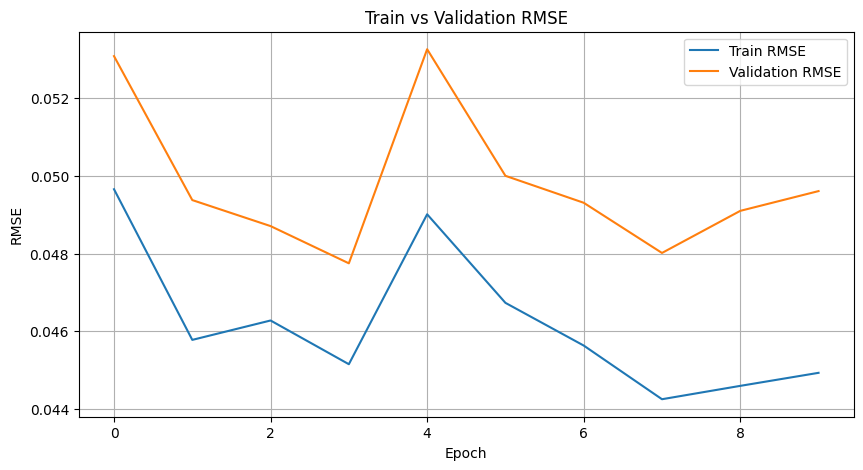

In [ ]:
# Using the train_losses and validation_losses lists filled during the training loop,

plt.figure(figsize=(10, 5))
plt.plot(epoch_values, train_losses, label='Train RMSE')
plt.plot(epoch_values, validation_losses, label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


### Without dropout

####1 layer

In [ ]:
class MultivariateLSTM(nn.Module):
    def __init__(self):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        x = x.view(x.size(0), -1)
        return x

In [ ]:
# Instantiating the model
model = MultivariateLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train_tensor = X_train.clone().detach().requires_grad_(False).float()
y_train_tensor = y_train.view(-1, 1)
X_val_tensor = X_val.clone().detach().requires_grad_(False).float()
y_val_tensor = y_val.view(-1, 1)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=8, shuffle=False)

# Train and validation RMSE calculation function
def calculate_rmse(model, data_loader):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            count += 1
    return np.sqrt(total_loss / count)

train_losses = []
validation_losses = []
epoch_values = []

# Training loop
n_epochs = 10
best_val_rmse = float('inf')

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

    # Calculate RMSE after each epoch
    train_rmse = calculate_rmse(model, train_loader)
    val_rmse = calculate_rmse(model, val_loader)
    print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f}")

    # Save best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'models/new/best_model_state_multi_dict.pth')

    # Store losses for each epoch
    train_losses.append(train_rmse)
    validation_losses.append(val_rmse)
    epoch_values.append(epoch)

final_train_rmse = calculate_rmse(model, train_loader)
final_val_rmse = calculate_rmse(model, val_loader)
print(f"Final: Train RMSE {final_train_rmse:.4f}, Validation RMSE {final_val_rmse:.4f}")
# Create a DataFrame with the results
final_results_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Validation RMSE'],
    'Value': [final_train_rmse, final_val_rmse]
})

final_results_df.to_csv('models/new/final_rmse_results_MultivariateLSTM_vanilla.csv', index=False)
# print(final_results_df)

Epoch 0: Train RMSE 0.0493, Validation RMSE 0.0523
Epoch 1: Train RMSE 0.0451, Validation RMSE 0.0475
Epoch 2: Train RMSE 0.0450, Validation RMSE 0.0480
Epoch 3: Train RMSE 0.0455, Validation RMSE 0.0479
Epoch 4: Train RMSE 0.0455, Validation RMSE 0.0485
Epoch 5: Train RMSE 0.0446, Validation RMSE 0.0482
Epoch 6: Train RMSE 0.0463, Validation RMSE 0.0499
Epoch 7: Train RMSE 0.0442, Validation RMSE 0.0478
Epoch 8: Train RMSE 0.0459, Validation RMSE 0.0493
Epoch 9: Train RMSE 0.0437, Validation RMSE 0.0472
Final: Train RMSE 0.0437, Validation RMSE 0.0472


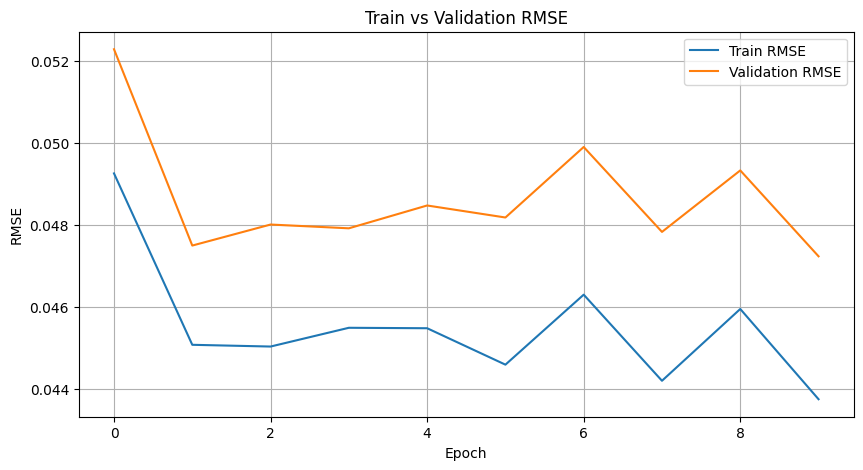

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_values, train_losses, label='Train RMSE')
plt.plot(epoch_values, validation_losses, label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

####2 layers

In [ ]:
class MultivariateLSTM(nn.Module):
    def __init__(self):
        super(MultivariateLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(50, 50, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Taking the output of the last LSTM cell
        x = self.linear(x)
        return x

In [ ]:
# Instantiating the model
model = MultivariateLSTM()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train_tensor = X_train.clone().detach().requires_grad_(False).float()
y_train_tensor = y_train.view(-1, 1)
X_val_tensor = X_val.clone().detach().requires_grad_(False).float()
y_val_tensor = y_val.view(-1, 1)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=8, shuffle=False)

# Train and validation RMSE calculation function
def calculate_rmse(model, data_loader):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            count += 1
    return np.sqrt(total_loss / count)

train_losses = []
validation_losses = []
epoch_values = []

# Training loop
n_epochs = 10
best_val_rmse = float('inf')

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

    # Calculate RMSE after each epoch
    train_rmse = calculate_rmse(model, train_loader)
    val_rmse = calculate_rmse(model, val_loader)
    print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f}")

    # Save best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'models/new/best_model_state_multi_dict.pth')

    # Store losses for each epoch
    train_losses.append(train_rmse)
    validation_losses.append(val_rmse)
    epoch_values.append(epoch)

final_train_rmse = calculate_rmse(model, train_loader)
final_val_rmse = calculate_rmse(model, val_loader)
print(f"Final: Train RMSE {final_train_rmse:.4f}, Validation RMSE {final_val_rmse:.4f}")
# Create a DataFrame with the results
final_results_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Validation RMSE'],
    'Value': [final_train_rmse, final_val_rmse]
})

final_results_df.to_csv('models/new/final_rmse_results_MultivariateLSTM.csv', index=False)
# print(final_results_df)

Epoch 0: Train RMSE 0.0463, Validation RMSE 0.0497
Epoch 1: Train RMSE 0.0473, Validation RMSE 0.0495
Epoch 2: Train RMSE 0.0450, Validation RMSE 0.0487
Epoch 3: Train RMSE 0.0451, Validation RMSE 0.0479
Epoch 4: Train RMSE 0.0446, Validation RMSE 0.0488
Epoch 5: Train RMSE 0.0447, Validation RMSE 0.0493
Epoch 6: Train RMSE 0.0438, Validation RMSE 0.0475
Epoch 7: Train RMSE 0.0443, Validation RMSE 0.0480
Epoch 8: Train RMSE 0.0438, Validation RMSE 0.0485
Epoch 9: Train RMSE 0.0430, Validation RMSE 0.0475
Final: Train RMSE 0.0430, Validation RMSE 0.0475


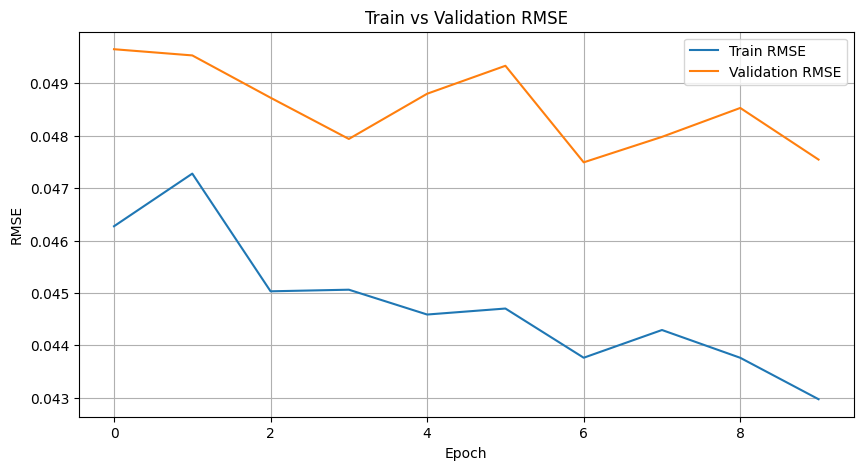

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_values, train_losses, label='Train RMSE')
plt.plot(epoch_values, validation_losses, label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

###Bidirectional LSTM

We now try Bidirectional LSTM to process the sequence both forward and backward, potentially giving the model more context.

In [ ]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2  # Bidirectional has two directions

        # First LSTM layer is bidirectional
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                             num_layers=num_layers, batch_first=True,
                             bidirectional=True)

        # Second LSTM layer (can also be bidirectional)
        self.lstm2 = nn.LSTM(hidden_size * self.num_directions, hidden_size,
                             batch_first=True, bidirectional=True)

        # Adjusting the input size of the linear layer to match the output of bidirectional LSTM
        self.linear = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Taking the output of the last time step from the final LSTM layer
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [ ]:
# Instantiating the model
model = MultivariateLSTM(input_size=input_size)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train_tensor = X_train.clone().detach().requires_grad_(False).float()
y_train_tensor = y_train.view(-1, 1)
X_val_tensor = X_val.clone().detach().requires_grad_(False).float()
y_val_tensor = y_val.view(-1, 1)

# DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=8, shuffle=False)

# Train and validation RMSE calculation function
def calculate_rmse(model, data_loader):
    model.eval()
    total_loss = 0
    count = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            count += 1
    return np.sqrt(total_loss / count)

train_losses = []
validation_losses = []
epoch_values = []

# Training loop
n_epochs = 10
best_val_rmse = float('inf')

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

    # Calculate RMSE after each epoch
    train_rmse = calculate_rmse(model, train_loader)
    val_rmse = calculate_rmse(model, val_loader)
    print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f}")

    # Save best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'models/new/best_model_state_multi__bi_dict.pth')

    # Store losses for each epoch
    train_losses.append(train_rmse)
    validation_losses.append(val_rmse)
    epoch_values.append(epoch)

final_train_rmse = calculate_rmse(model, train_loader)
final_val_rmse = calculate_rmse(model, val_loader)
print(f"Final: Train RMSE {final_train_rmse:.4f}, Validation RMSE {final_val_rmse:.4f}")
# Create a DataFrame with the results
final_results_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Validation RMSE'],
    'Value': [final_train_rmse, final_val_rmse]
})

final_results_df.to_csv('models/new/final_rmse_results_MultivariateLSTM_bi.csv', index=False)
# print(final_results_df)

MultivariateLSTM(
  (lstm1): LSTM(55, 50, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Epoch 0: Train RMSE 0.0472, Validation RMSE 0.0497
Epoch 1: Train RMSE 0.0467, Validation RMSE 0.0506
Epoch 2: Train RMSE 0.0467, Validation RMSE 0.0494
Epoch 3: Train RMSE 0.0486, Validation RMSE 0.0519
Epoch 4: Train RMSE 0.0455, Validation RMSE 0.0476
Epoch 5: Train RMSE 0.0458, Validation RMSE 0.0492
Epoch 6: Train RMSE 0.0455, Validation RMSE 0.0501
Epoch 7: Train RMSE 0.0444, Validation RMSE 0.0488
Epoch 8: Train RMSE 0.0434, Validation RMSE 0.0483
Epoch 9: Train RMSE 0.0436, Validation RMSE 0.0489
Final: Train RMSE 0.0436, Validation RMSE 0.0489


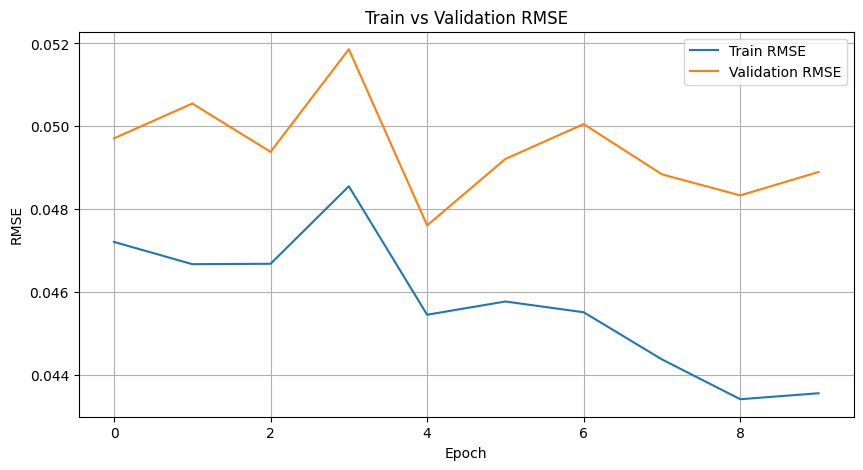

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_values, train_losses, label='Train RMSE')
plt.plot(epoch_values, validation_losses, label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

##Tunning

**Number of Layers**: Experiment with adding more LSTM layers to increase the model's capacity to learn complex patterns.<br>
**Hidden Units**: Adjust the number of hidden units in each LSTM layer. More units can capture more complexity but may lead to overfitting. <br>
**Learning Rate**: Experiment with different learning rates. Sometimes a smaller learning rate with more epochs can lead to better performance. <br>
**Batch Size**: Try different batch sizes. Smaller batch sizes can provide regularization effects, while larger batch sizes may speed up training

In [ ]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(MultivariateLSTM, self).__init__()
        # For simplicity, we assume all layers have the same hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,
                            bidirectional=False)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Taking the output of the last LSTM cell
        x = self.linear(x)
        return x


In [ ]:
from itertools import product

# Hyperparameter ranges
num_layers_options = [1]#, 2, 3]
hidden_units_options = [8]#,32, 64]
learning_rate_options = [0.001]#, 0.01, 0.1]
batch_size_options = [8] #, 16, 32]

# Create a grid of all hyperparameter combinations
hyperparameter_grid = product(num_layers_options, hidden_units_options,
                              learning_rate_options, batch_size_options)

results = []

for num_layers, hidden_units, learning_rate, batch_size in hyperparameter_grid:
    # Initialize model, optimizer, and dataloaders for this combination
    model = MultivariateLSTM(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

    best_val_rmse = float('inf')
    best_model_path = f'models/new/best_model_state_{num_layers}_{hidden_units}_{learning_rate}_{batch_size}.pth'

    def calculate_rmse(model, data_loader):
      model.eval()
      total_loss = 0
      count = 0
      with torch.no_grad():
          for X_batch, y_batch in data_loader:
              y_pred = model(X_batch)
              loss = loss_fn(y_pred, y_batch)
              total_loss += loss.item()
              count += 1
      return np.sqrt(total_loss / count)

    train_losses = []
    validation_losses = []
    epoch_values = []

    # Training loop
    n_epochs = 10
    best_val_rmse = float('inf')
    # best_model_path = 'best_model_state.pth'
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

        # Calculate RMSE after each epoch
        train_rmse = calculate_rmse(model, train_loader)
        val_rmse = calculate_rmse(model, val_loader)
        # print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Validation RMSE {val_rmse:.4f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), best_model_path)

    # Load the best model from this training iteration
    model.load_state_dict(torch.load(best_model_path))

    # Calculate final RMSEs
    final_train_rmse = calculate_rmse(model, train_loader)
    final_val_rmse = calculate_rmse(model, val_loader)

    # Store the results
    results.append({
        'num_layers': num_layers,
        'hidden_units': hidden_units,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'final_train_rmse': final_train_rmse,
        'final_val_rmse': final_val_rmse
    })

    # Print results for this combination
    print(f"Combination: Layers={num_layers}, Hidden={hidden_units}, LR={learning_rate}, Batch={batch_size}, Train RMSE={final_train_rmse:.4f}, Val RMSE={final_val_rmse:.4f}")

    if final_val_rmse < best_val_rmse:
        best_val_rmse = final_val_rmse
        best_combination = {
            'num_layers': num_layers,
            'hidden_units': hidden_units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'train_rmse': final_train_rmse,
            'val_rmse': final_val_rmse
        }



Combination: Layers=1, Hidden=8, LR=0.001, Batch=8, Train RMSE=0.0442, Val RMSE=0.0482


In [ ]:

# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('models/new/final_rmse_results_MultivariateLSTM_tunning.csv', index=False)

best_row = results_df.loc[results_df['final_val_rmse'].idxmin()]

print("Best RMSE results:")
print(best_row)

Best RMSE results:
num_layers          1.000000
hidden_units        8.000000
learning_rate       0.001000
batch_size          8.000000
final_train_rmse    0.044202
final_val_rmse      0.048243
Name: 0, dtype: float64


In [ ]:
import seaborn as sns

# Use color to represent different learning rates
plt.figure(figsize=(12, 7))
sns.scatterplot(data=results_df, x='Batch Size', y='Validation Loss', hue='Learning Rate', palette='viridis', s=300)

# Adding plot title and labels
plt.title('Validation Loss for Different Batch Sizes and Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('Validation Loss')
plt.legend(title='Learning Rate')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
num_layers = int(best_row['num_layers'])
hidden_units=int(best_row['hidden_units'])
learning_rate=best_row['learning_rate']
batch_size=int(best_row['batch_size'])
best_model_path=f'models/new/best_model_state_{num_layers}_{hidden_units}_{learning_rate}_{batch_size}.pth'

TEST DATA RUN

In [ ]:
file_test = 'data/test_imputed.csv'
file_train = 'data/train_val_imputed.csv'

In [ ]:
def create_dataset(datasetx,datasety, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(datasetx)-lookback):
        feature = datasetx[i:(i + lookback)]
        target = datasety[i + lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


def generate_data(lookback,
                  file_train=file_train, file_test=file_test,
                  predvar='no2', exog=[], plot=False):
  # Read and visualize data
  df=pd.read_csv(file_train)
  test=pd.read_csv(file_test)
  timeseries=pd.concat([df,test], ignore_index=True)[["no2"]].values.astype('float32')
  train_size=len(df)
  test_size = len(timeseries) - train_size
  print(f"Train size: {train_size}\nTest size: {test_size}")
  train, val = timeseries[:train_size], timeseries[train_size:]

  if plot:
    plt.plot(train)
    plt.show()

    plt.plot(val)
    plt.show()

  lookback = 1
  # normalize data
  scalerx = MinMaxScaler(feature_range=(0,1))
  scalery = MinMaxScaler(feature_range=(0,1))

  # scaling dataset
  scaled_trainx = scalerx.fit_transform(train)
  scaled_trainy = scalery.fit_transform(train[:,0].reshape(-1, 1))

  # scale validation
  scaled_testx = scalerx.transform(val)
  scaled_testy = scalery.transform(val[:,0].reshape(-1, 1))

  # Creating train and test datasets for LSTM
  X_train, y_train = create_dataset(scaled_trainx,scaled_trainy, lookback=lookback)
  X_test, y_test = create_dataset(scaled_testx,scaled_testy, lookback=lookback)


  # Displaying the shape of the datasets
  X_train.shape, y_train.shape, X_test.shape, y_test.shape

  return timeseries, train_size, train, test, scalerx, scalery, X_train, y_train, X_test, y_test

In [ ]:
# ADJUST VARIABLES
predvar='no2'
exog=cols_specific_hday +cols_weekday+cols_month+cols_hour
lookback = 1
# lookback=168
input_size=len(exog)+1

timeseries, train_size, train, test, scalerx, scalery, X_train, y_train, X_test, y_test=generate_data(lookback=lookback,
                                                                    file_train=file_train, file_test=file_test,
                                                                    predvar='no2', exog=exog, plot=False)

Train size: 21936
Test size: 433


In [ ]:
# Recreate the scaler
scaler = MinMaxScaler()

# Assuming you have access to the original training data target variable
scaler.fit(train.reshape(-1, 1))

# Load the best model
best_model_path = best_model_path #'models/new/best_model_state_1_64_0.1_32.pth' #best_model_path
model = MultivariateLSTM(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers)
model.load_state_dict(torch.load(best_model_path))

# Ensure model is in evaluation mode
# model.eval()

# X_test_tensor = X_test.clone().detach().requires_grad_(False).float()
# y_test_tensor = y_test.clone().detach().requires_grad_(False).float().view(-1, 1)
# X_train_tensor = X_train.clone().detach().requires_grad_(False).float()
# y_train_tensor = y_train.clone().detach().requires_grad_(False).float().view(-1, 1)

# Prepare DataLoader for the test data
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
#                                           batch_size=32, shuffle=False)
# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
#                                           batch_size=32, shuffle=False)
# loss_fn = nn.MSELoss()

def calculate_rmse_and_denormalize(model, data_loader, scaler):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    # Denormalize if scaler is provided
    if scaler:
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)

    # Calculate RMSE
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)

    return rmse, predictions, actuals

# Assume 'scaler' is your MinMaxScaler that was fitted on the target variable of the training data
test_rmse, test_predictions, test_actuals = calculate_rmse_and_denormalize(model, test_loader, scaler)
train_rmse, train_predictions, train_actuals = calculate_rmse_and_denormalize(model, train_loader, scaler)

print(f"Train RMSE on original scale: {train_rmse:.4f}")
print(f"Test RMSE on original scale: {test_rmse:.4f}")


Train RMSE on original scale: 15.7156
Test RMSE on original scale: 17.7060


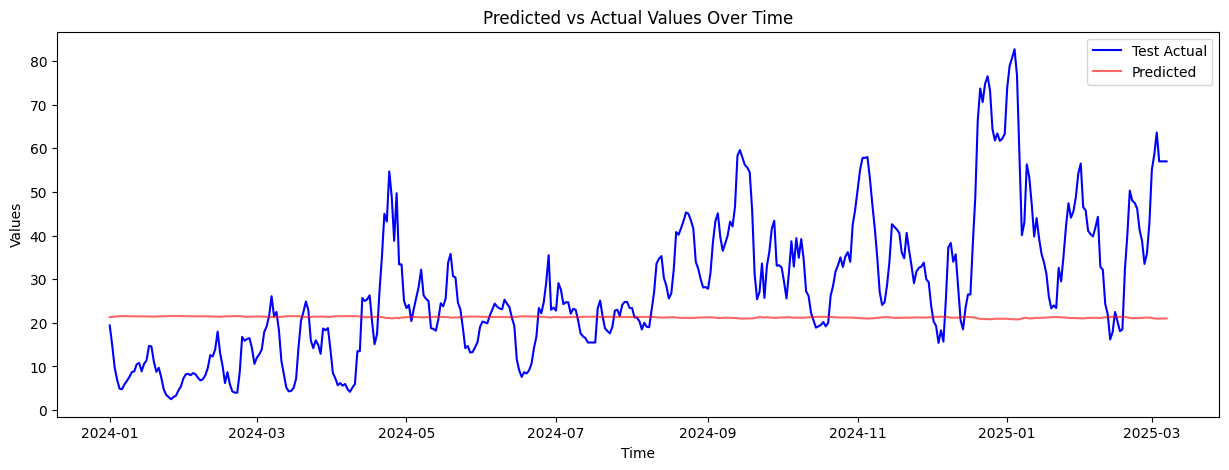

In [ ]:
# Replace 'dates' with your actual datetime series
dates = pd.date_range(start='2024-01-01', periods=len(test_predictions), freq='D')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(dates, test_actuals, label='Test Actual', color='blue')
plt.plot(dates, test_predictions, label='Predicted', color='red', alpha=0.6)
plt.title('Predicted vs Actual Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()